In [34]:
import numpy as np
import pandas as pd 
import h5py
import convert_data

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import Normalize, LogNorm

from sklearn.utils import shuffle

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

np.random.seed(7)

images, labels = convert_data.images_and_labels()

In [35]:
x_tr, x_val, y_tr, y_val = train_test_split(images, labels, test_size=0.33, random_state=42)
x_val, x_te, y_val, y_te = train_test_split(x_val, y_val, test_size=0.33, random_state=42)

# Model Creation

Here is actually where we define our model

In [36]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                 input_shape=(26,32,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

batch_size = 32
epochs = 20

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 32, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 32, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 32, 32)        9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 26, 32, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 16, 64)        18496     
__________

In [38]:
history = model.fit(x_tr, y_tr, validation_data = (x_val, y_val) ,epochs = epochs, verbose=2, callbacks = [reduce_lr], batch_size = batch_size)

Train on 1340 samples, validate on 442 samples
Epoch 1/20
 - 20s - loss: 0.6502 - acc: 0.7627 - val_loss: 0.6276 - val_acc: 0.7986
Epoch 2/20
 - 13s - loss: 0.4688 - acc: 0.8157 - val_loss: 0.6598 - val_acc: 0.8416
Epoch 3/20
 - 14s - loss: 0.4115 - acc: 0.8373 - val_loss: 0.6023 - val_acc: 0.8145
Epoch 4/20
 - 14s - loss: 0.4114 - acc: 0.8239 - val_loss: 0.8093 - val_acc: 0.8100
Epoch 5/20
 - 14s - loss: 0.3487 - acc: 0.8552 - val_loss: 0.8040 - val_acc: 0.7964
Epoch 6/20
 - 13s - loss: 0.3166 - acc: 0.8604 - val_loss: 0.6733 - val_acc: 0.8235
Epoch 7/20
 - 13s - loss: 0.2692 - acc: 0.8896 - val_loss: 0.5784 - val_acc: 0.8054
Epoch 8/20
 - 13s - loss: 0.2690 - acc: 0.8955 - val_loss: 0.6489 - val_acc: 0.8009
Epoch 9/20
 - 13s - loss: 0.2354 - acc: 0.8985 - val_loss: 0.7007 - val_acc: 0.7873
Epoch 10/20
 - 14s - loss: 0.2086 - acc: 0.9172 - val_loss: 0.6123 - val_acc: 0.8054
Epoch 11/20
 - 13s - loss: 0.2234 - acc: 0.9119 - val_loss: 0.6898 - val_acc: 0.8054
Epoch 12/20
 - 13s - loss: 

In [39]:
scores = model.evaluate(x_te, y_te, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 21.10%


In [40]:
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss', 'lr']


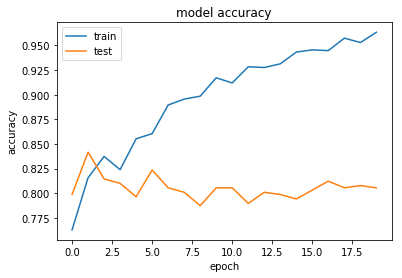

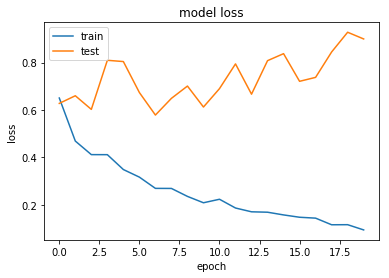

In [41]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
from sklearn.metrics import roc_curve

y_pred_keras = model.predict(x_te).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_te, y_pred_keras)

In [43]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

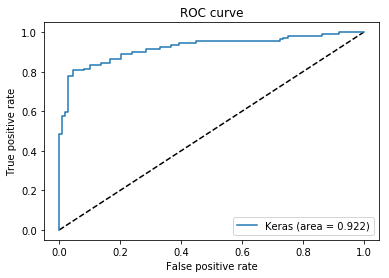

In [44]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Conclusion

We are able to get good accuracy on the data given this model. However, it takes a long time and has a lot of parameters. Furthermore, it is overfitting as can be seen from the 
